# Small-PC1 Alignment Toward Custom 3D Target

This notebook builds a small recurrent network, computes its stimulus responses, and optimizes neuron-specific gains so the color modulation axis aligns with a user-defined direction in the principal-component space.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 keeps 3D projection registered
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(21)

N = 120
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

In [ ]:
# Enable an interactive Matplotlib backend if available
from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    try:
        import ipympl  # noqa: F401 ensures ipympl is on sys.path
        _ip.run_line_magic('matplotlib', 'widget')
        print('Using %matplotlib widget backend')
    except Exception as err:
        print(f'%matplotlib widget unavailable ({err}); trying notebook backend')
        try:
            _ip.run_line_magic('matplotlib', 'notebook')
            print('Using %matplotlib notebook backend')
        except Exception as err2:
            print(f'%matplotlib notebook unavailable ({err2}); falling back to inline rendering')
            _ip.run_line_magic('matplotlib', 'inline')
else:
    print('No active IPython shell; matplotlib backend not changed')


Using %matplotlib widget backend


In [ ]:
def initialize_selectivity_matrix(N, K):
    '''Build paired shape/color selectivity profiles with complementary halves.'''
    S = np.zeros((N, K))
    halfN = N // 2

    S[:halfN, 0] = np.random.rand(halfN)
    S[:halfN, 1] = 0.5 - S[:halfN, 0] / 2

    neg_idx = (S[:halfN, 0] - S[:halfN, 1]) < 0
    if np.any(neg_idx):
        S[:halfN, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
        S[:halfN, 1][neg_idx] = 0.5 - S[:halfN, 0][neg_idx] / 2

    S[halfN:, 1] = S[:halfN, 0]
    S[halfN:, 0] = S[:halfN, 1]
    return S


def initialize_W_F(S, shape_scale=1.0, color_scale=1.0):
    '''Scale shape/color drive separately, then normalize each neuron.'''
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        s_val = shape_scale * S[i, 0]
        c_val = color_scale * S[i, 1]
        row_sum = s_val + c_val
        if row_sum > 0:
            W_F[i, 0] = s_val / row_sum
            W_F[i, 1] = c_val / row_sum
    return W_F


def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    '''Generate block-structured recurrent weights and enforce zero row sums.'''
    halfN = N // 2
    W_R = np.zeros((N, N))

    rand_ss = np.random.rand(halfN, halfN)
    mask_ss = rand_ss < p_high
    block_ss = np.zeros((halfN, halfN))
    block_ss[mask_ss] = np.random.rand(np.sum(mask_ss)) * 0.1

    W_R[:halfN, :halfN] = block_ss
    W_R[halfN:, halfN:] = block_ss

    rand_sc = np.random.rand(halfN, halfN)
    mask_sc = rand_sc < p_low
    block_sc = np.zeros((halfN, halfN))
    block_sc[mask_sc] = np.random.rand(np.sum(mask_sc)) * 0.1

    W_R[:halfN, halfN:] = block_sc
    W_R[halfN:, :halfN] = block_sc

    np.fill_diagonal(W_R, 0)

    for i in range(N):
        row_sum = np.sum(W_R[i, :])
        W_R[i, :] -= row_sum / N
    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    dist = np.linalg.norm(S[i] - S[j])
                    if dist < thresh:
                        W_R[i, j] *= (2.0 - dist / thresh)
        np.fill_diagonal(W_R, 0)

    eigvals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eigvals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R


def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F
    stim = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ stim)


def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    responses = []
    for shape_val in shape_vals:
        for color_val in color_vals:
            responses.append(compute_response(W_R, W_F, shape_val, color_val, g_vector))
    return np.array(responses)

def line3d(ax, v, origin=(0,0,0), two_sided=False, length=None, **kw):
    v = np.asarray(v, float).ravel()
    o = np.asarray(origin, float).ravel()

    # Optional: set a specific length
    if length is not None:
        n = np.linalg.norm(v)
        if n > 0:
            v = v / n * float(length)

    if two_sided:
        p0, p1 = o - v, o + v
    else:
        p0, p1 = o, o + v

    ax.plot3D([p0[0], p1[0]], [p0[1], p1[1]], [p0[2], p1[2]], **kw)

Running SLSQP (color-axis norm equality + ball constraint)...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.20998442473923634
            Iterations: 30
            Function evaluations: 3631
            Gradient evaluations: 30
Optimization success: True
Final objective: -0.20998442473923634
Angle pre-modulation:  79.843 deg
Angle post-modulation: 62.726 deg
Improvement:           17.117 deg
Initial ||color axis||: 7.8418
Final   ||color axis||: 7.8418
Ball residual: -7.5023e-11


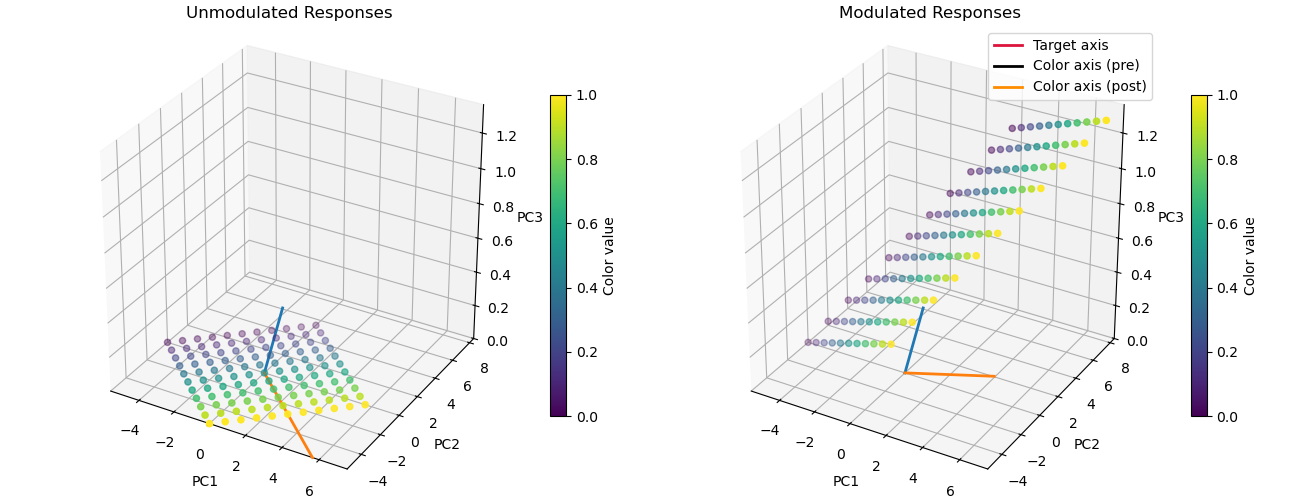

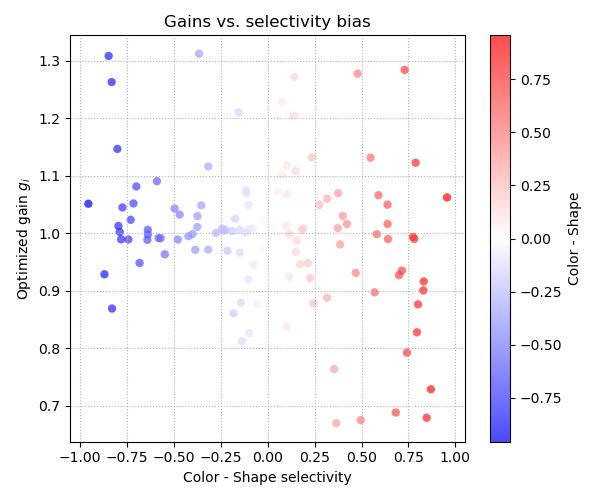

In [ ]:
# 1. Build the network and compute unmodulated responses
S = initialize_selectivity_matrix(N, K)
W_F = initialize_W_F(S)
W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

grid_points = 11
shape_vals = np.linspace(0, 1, grid_points)
color_vals = np.linspace(0, 1, grid_points)
color_list = np.array([c for _s in shape_vals for c in color_vals])

responses_grid_unmod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None)

# 2. PCA basis (top 3 PCs) and target direction in that space
pca_grid = PCA(n_components=3)
pca_grid.fit(responses_grid_unmod)
v1, v2, v3 = [vec / np.linalg.norm(vec) for vec in pca_grid.components_]

# Define target via two angles: theta sets direction inside PC1-PC2, phi mixes in a vector orthogonal to the PC1-PC3 plane.
theta_deg = 35.0
phi_deg = 22.5
theta = np.deg2rad(theta_deg)
phi = np.deg2rad(phi_deg)



base_dir_pc = np.array([np.cos(theta), np.sin(theta), 0.0])
base_dir_pc /= np.linalg.norm(base_dir_pc)

lift_pc = np.array([0.0, 0.0, 1.0])

# Combine the in-plane direction with a PC3 component so projection onto PC3 is non-zero.
target_pc = np.cos(phi) * base_dir_pc + np.sin(phi) * lift_pc
target_pc /= np.linalg.norm(target_pc)

target_vec = (
    target_pc[0] * v1
    + target_pc[1] * v2
    + target_pc[2] * v3
)
target_vec /= np.linalg.norm(target_vec)

shape_for_color_line = 0.3


def color_axis_direction(g):
    resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
    resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
    return resp_c1 - resp_c0


init_g = np.ones(N)
d_unmod = color_axis_direction(init_g)
norm_unmod_sq = np.linalg.norm(d_unmod) ** 2


# 3. Optimization with equality (norm) + ball constraint
def alignment_objective(g):
    d_col = color_axis_direction(g)
    denom = np.linalg.norm(d_col) * np.linalg.norm(target_vec)
    if denom < 1e-15:
        return 0.0
    cos_val = np.dot(d_col, target_vec) / denom
    cos_val = np.clip(cos_val, -1.0, 1.0)
    return -(cos_val ** 2)


def color_axis_norm_constraint(g):
    d_col = color_axis_direction(g)
    return np.linalg.norm(d_col) ** 2 - norm_unmod_sq


R = 0.12 * np.sqrt(N)

def ball_constraint(g):
    return R - np.linalg.norm(g - np.ones(N))


constraints = [
    {'type': 'eq', 'fun': color_axis_norm_constraint},
    {'type': 'ineq', 'fun': ball_constraint},
]

print('Running SLSQP (color-axis norm equality + ball constraint)...')
res = minimize(
    fun=alignment_objective,
    x0=init_g,
    method='SLSQP',
    constraints=constraints,
    options={'maxiter': 400, 'ftol': 1e-9, 'disp': True},
)

g_opt = res.x
print('Optimization success:', res.success)
print('Final objective:', res.fun)


def axis_angle(vec):
    denom = np.linalg.norm(vec) * np.linalg.norm(target_vec)
    if denom < 1e-15:
        return np.nan
    cos_val = np.dot(vec, target_vec) / denom
    cos_val = np.clip(cos_val, -1.0, 1.0)
    ang = np.degrees(np.arccos(cos_val))
    return min(ang, 180.0 - ang)


d_mod = color_axis_direction(g_opt)
angle_pre = axis_angle(d_unmod)
angle_post = axis_angle(d_mod)
print(f'Angle pre-modulation:  {angle_pre:.3f} deg')
print(f'Angle post-modulation: {angle_post:.3f} deg')
print(f'Improvement:           {angle_pre - angle_post:.3f} deg')

print(f'Initial ||color axis||: {np.sqrt(norm_unmod_sq):.4f}')
print(f'Final   ||color axis||: {np.linalg.norm(d_mod):.4f}')
print(f'Ball residual: {ball_constraint(g_opt):.4e}')


responses_grid_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=g_opt)
proj_unmod = pca_grid.transform(responses_grid_unmod)
proj_mod = pca_grid.transform(responses_grid_mod)

target_pc_coords = pca_grid.components_ @ target_vec
axis_unmod_pc = pca_grid.components_ @ d_unmod
axis_mod_pc = pca_grid.components_ @ d_mod

mins = np.minimum(proj_unmod.min(axis=0), proj_mod.min(axis=0))
maxs = np.maximum(proj_unmod.max(axis=0), proj_mod.max(axis=0))

fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

sc1 = ax1.scatter(proj_unmod[:, 0], proj_unmod[:, 1], proj_unmod[:, 2], c=color_list, cmap='viridis', s=20)
sc2 = ax2.scatter(proj_mod[:, 0], proj_mod[:, 1], proj_mod[:, 2], c=color_list, cmap='viridis', s=20)

line3d(ax1, target_pc_coords, two_sided=False, linewidth=2)
line3d(ax1, axis_unmod_pc,   two_sided=False, linewidth=2)
line3d(ax2, target_pc_coords, two_sided=False, linewidth=2)
line3d(ax2, axis_mod_pc,      two_sided=False, linewidth=2)

for ax in (ax1, ax2):
    ax.set_xlim([mins[0], maxs[0]])
    ax.set_ylim([mins[1], maxs[1]])
    ax.set_zlim([mins[2], maxs[2]])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_box_aspect((1, 1, 1))

ax1.set_title('Unmodulated Responses')
ax2.set_title('Modulated Responses')

legend_elements = [
    Line2D([0], [0], color='crimson', lw=2, label='Target axis'),
    Line2D([0], [0], color='black', lw=2, label='Color axis (pre)'),
    Line2D([0], [0], color='darkorange', lw=2, label='Color axis (post)'),
]
ax2.legend(handles=legend_elements, loc='upper right')

cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
cb1.set_label('Color value')
cb2.set_label('Color value')
plt.tight_layout()
plt.show()


color_diff = S[:, 1] - S[:, 0]
fig2 = plt.figure(figsize=(6, 5))
plt.scatter(color_diff, g_opt, c=color_diff, cmap='bwr', alpha=0.7, edgecolors='none')
plt.xlabel('Color - Shape selectivity')
plt.ylabel('Optimized gain $g_i$')
plt.title('Gains vs. selectivity bias')
cb = plt.colorbar()
cb.set_label('Color - Shape')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()